In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

In [5]:
import elevation.prediction_pipeline
import matplotlib.pyplot as plt
import numpy as np
import azimuth.util as util
import scipy as sp
import scipy.stats as st
import sklearn
import sklearn.cross_validation
from elevation.prediction_pipeline import *

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [6]:
import matplotlib

In [7]:
np.random.seed(1234)

In [8]:
best_model = 'linear-raw-stacker'

In [92]:
learn_options = {    'num_proc': 10,
                     'nuc_features_WT': False, 'include_pi_nuc_feat': False,
                     'annotation position one-hot': False,
                     'mutation_type' : False,
                     'mutation_details' : False,
                     'annotation_onehot' : False, # featurize like CFD
                     'annotation_decoupled_onehot' : ['let', 'pos', 'transl'], # decouple the CFD features into letters and position
                     "include_Tm": False,
                     'include_azimuth_score': None, # all of them ["WT","MUT","DELTA"]
                     'azimuth_feat' : ['WT'], # ['WT'], #['WT'],#["MUT", "WT"],
                     "include_gene_position": False,
                     "cv": "stratified",
                     'adaboost_loss' : 'ls',
                     'adaboost_CV': False, "algorithm_hyperparam_search" : "grid",
                     'n_folds' : 10,
                     'allowed_category' : None,#"Mismatch",#"Insertion",
                     "include_NGGX_interaction": False,
                     'normalize_features' : False, 'class_weight': None,
                     "phen_transform": 'kde_cdf', #  'kde_cdf',
                     "training_metric": 'spearmanr',
                     "skip_pam_feat" : True, "letpos_indep_ft": False, "letpos_inter_ft": True,
                     "fit_intercept" : True,
                     "seed" : 12345,
                     "num_proc": 1,
                     "alpha": np.array([1.0e-3]),
                     "V": "CD33",
                     "left_right_guide_ind": [4,27,30], # 23-mer
                     "order": 1,
                     "testing_non_binary_target_name": 'ranks',
                     'models': ['AdaBoost'],
                     'post-process Platt': False,
                     'azimuth_score_in_stacker': False,
                     'use_mut_distances': False,
                     'guide_seq_full': False,
                     'reload guideseq': True,
                     "renormalize_guideseq": True,
                    ' sdfdkjdslsdjf': True
             }

# Load all datasets

In [93]:
guideseq_data = elevation.prediction_pipeline.load_guideseq(learn_options, filterPAMs=True, subsample_zeros=False)
guideseq_data_nofilter = elevation.prediction_pipeline.load_guideseq(learn_options, filterPAMs=False, subsample_zeros=False)
# mouse_data = elevation.prediction_pipeline.load_mouse(learn_options)
# hsu_data = elevation.prediction_pipeline.load_Hsu(learn_options)
frock_data_ST3 = elevation.prediction_pipeline.load_Frocketal(learn_options, which_table=3, filterPAMs=False)
frock_data_ST7 = elevation.prediction_pipeline.load_Frocketal(learn_options, which_table=7, filterPAMs=False)
cd33_data = elevation.load_data.load_cd33(learn_options)[0]
cd33_data['Annotation'] = cd33_data['Annotation'].apply(lambda x: [x])

reading GuideSeq data and saving to pickle...
Done.
reading GuideSeq data and saving to pickle...
Done.
loading processed data from file: ../../data/offtarget/CD33.processed.[4, 27, 30].pamfiltTrue.p...
done.
{'bandwidth': 0.23000000000000001}


In [59]:
guideseq_data.shape

(354, 12)

# Train base model

In [94]:
base_model, base_feature_names = elevation.prediction_pipeline.train_base_model(learn_options)

Received option CV=False, so I'm training using all of the data
running AdaBoost, order 1 for final
MKL not available, so I'm not adjusting the number of threads
Launching 1 jobs with 1 MKL threads each
loading processed data from file: ../../data/offtarget/CD33.processed.[4, 27, 30].pamfiltTrue.p...
done.
{'bandwidth': 0.23000000000000001}
featurizing data...
done.
range of y_all is [0.000002, 1.000000]
filename = VCD33AdaBoostRegressor.order1Day21-ETP.gene.spearman
Cross-validating genes...
		RMSE:  0.181818754071
		Spearman correlation:  0.804940180452
		finished fold/gene 1 of 1
		median spearmanr across gene folds: 0.805
		Elapsed time for cv is 1.02 seconds


# Guide-Seq data (n=402)

Best median for linear-raw-stacker: 0.535, GP-stacker: 0.577
with just decoupled + o1 WT azimuth linear stacker = 0.605

In [95]:
preds_guideseq = elevation.prediction_pipeline.predict_guideseq(base_model, guideseq_data, learn_options,
                                                                naive_bayes_combine=True)
preds_guideseq_nofilter = elevation.prediction_pipeline.predict_guideseq(base_model, guideseq_data_nofilter, learn_options,
                                                                naive_bayes_combine=True)

loading processed data from file: ../../data/offtarget/CD33.processed.None.pamfiltTrue.p...
done.
{'bandwidth': 0.23000000000000001}
loading processed data from file: ../../data/offtarget/CD33.processed.None.pamfiltTrue.p...
done.
{'bandwidth': 0.23000000000000001}


In [61]:
predictions_gs, performance_gs, mismatches_gs, truth_gs, c_pred =  elevation.prediction_pipeline.cross_validate_guideseq(guideseq_data, 
                                                                                                     preds_guideseq, 
                                                                                                     learn_options,
                                                                                models= ['CFD', 'product',
                                                                               'HsuZhang', 'linear-raw-stacker',
                                                                                         #'GBRT-raw-stacker',
                                                                                        'constant-power', 'CCTOP'])

Loading CFD table from file
Fold 1, Spearman r: product=0.305 HsuZhang=0.477 CCTOP=0.475 constant-power=0.171 linear-raw-stacker=0.444 CFD=0.426 
Loading CFD table from file
Fold 2, Spearman r: product=0.580 HsuZhang=0.628 CCTOP=0.631 constant-power=0.570 linear-raw-stacker=0.648 CFD=0.558 
Loading CFD table from file
Fold 3, Spearman r: product=0.452 HsuZhang=0.339 CCTOP=0.137 constant-power=0.552 linear-raw-stacker=0.432 CFD=0.094 
Loading CFD table from file
Fold 4, Spearman r: product=0.173 HsuZhang=0.382 CCTOP=0.296 constant-power=0.164 linear-raw-stacker=0.263 CFD=0.069 
Loading CFD table from file
Fold 5, Spearman r: product=0.472 HsuZhang=0.424 CCTOP=0.473 constant-power=0.352 linear-raw-stacker=0.611 CFD=0.531 
Loading CFD table from file
Fold 6, Spearman r: product=0.719 HsuZhang=0.782 CCTOP=0.720 constant-power=0.638 linear-raw-stacker=0.620 CFD=0.387 
Loading CFD table from file
Fold 7, Spearman r: product=0.546 HsuZhang=0.639 CCTOP=0.608 constant-power=0.276 linear-raw-sta

 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


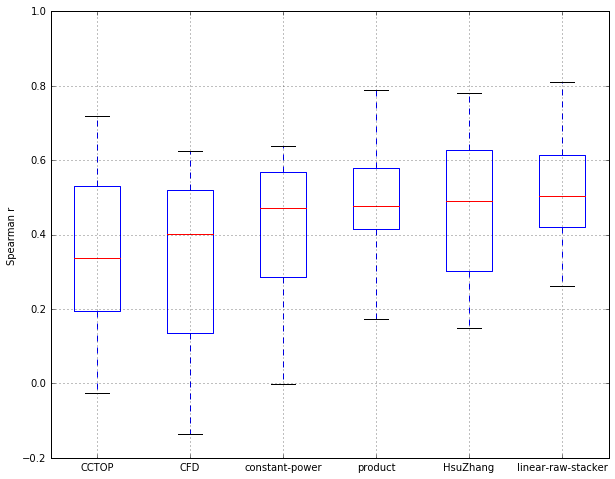

In [62]:
plt.figure(figsize=(10,8))
med=performance_gs.T.median()
med.sort_values(inplace=True)
performance_sorted=performance_gs.T[med.index]
performance_sorted.boxplot()
plt.ylabel('Spearman r')

In [1171]:
%%capture
rep = 1
predictions_repeated = dict([(k, np.ones((guideseq_data.shape[0], rep))) for k in predictions_gs.keys()])

for r in range(rep):

    predictions, performance, mismatches, truth, c_pred =  elevation.prediction_pipeline.cross_validate_guideseq(guideseq_data, 
                                                                                                     preds_guideseq, 
                                                                                                     learn_options,
                                                                                models= ['CFD', 'product',
                                                                               'linear-raw-stacker'],
                                                                                                     seed=r)
    for model in predictions.keys():
        predictions_repeated[model][:,r] = c_pred[model].flatten()

In [1172]:
all_cfd_pred = predictions_repeated['CFD'][:,0] # no stochasticity in CFD, so pred all the same across folds
all_best_model_pred = predictions_repeated[best_model].mean(1)
all_product_pred = predictions_repeated['product'][:, 0]
all_truth = guideseq_data['GUIDE-SEQ Reads'].values.copy()
all_mismatches = guideseq_data['Annotation'].apply(len).values

In [1173]:
assert np.allclose(sp.stats.pearsonr(all_cfd_pred, all_truth)[0], 0.409, atol=1e-3)

AssertionError: 

In [1174]:
%%capture
num_mismatches = guideseq_data['Annotation'].apply(len).values
mismatches = np.sort(np.unique(num_mismatches))
results = []
test_ind = []
for m in mismatches:
    train = num_mismatches!=m
    test = num_mismatches==m
    # if test.sum() > 50:
    #     ind_to_remove = np.random.permutation(np.where(test)[0][50:])
    #     test[ind_to_remove] = False
    #     train[ind_to_remove] = True
    print m, train.sum(), test.sum()
    test_ind.append(test)
    preds_guideseq_cv = predict_guideseq(base_model, guideseq_data[train], learn_options,
                                                            naive_bayes_combine=True)
    nb_pred, individual_pred = predict(base_model, guideseq_data[test], learn_options)

    preds = stacked_predictions(guideseq_data[test], individual_pred,
                                guideseq_data=guideseq_data[train],
                                                           models=['product', 'linear-raw-stacker',
                                                                   'CFD',],
                                                           preds_guideseq=preds_guideseq_cv,
                                                           use_mut_distances=False,
                                                           prob_calibration_model=None,
                                                           learn_options=learn_options)
    results.append(preds)



2 0.0570963862703
3 0.330149379727
4 0.158887472912
5 0.0597499239682
6 0.436644032168


(2, 6)

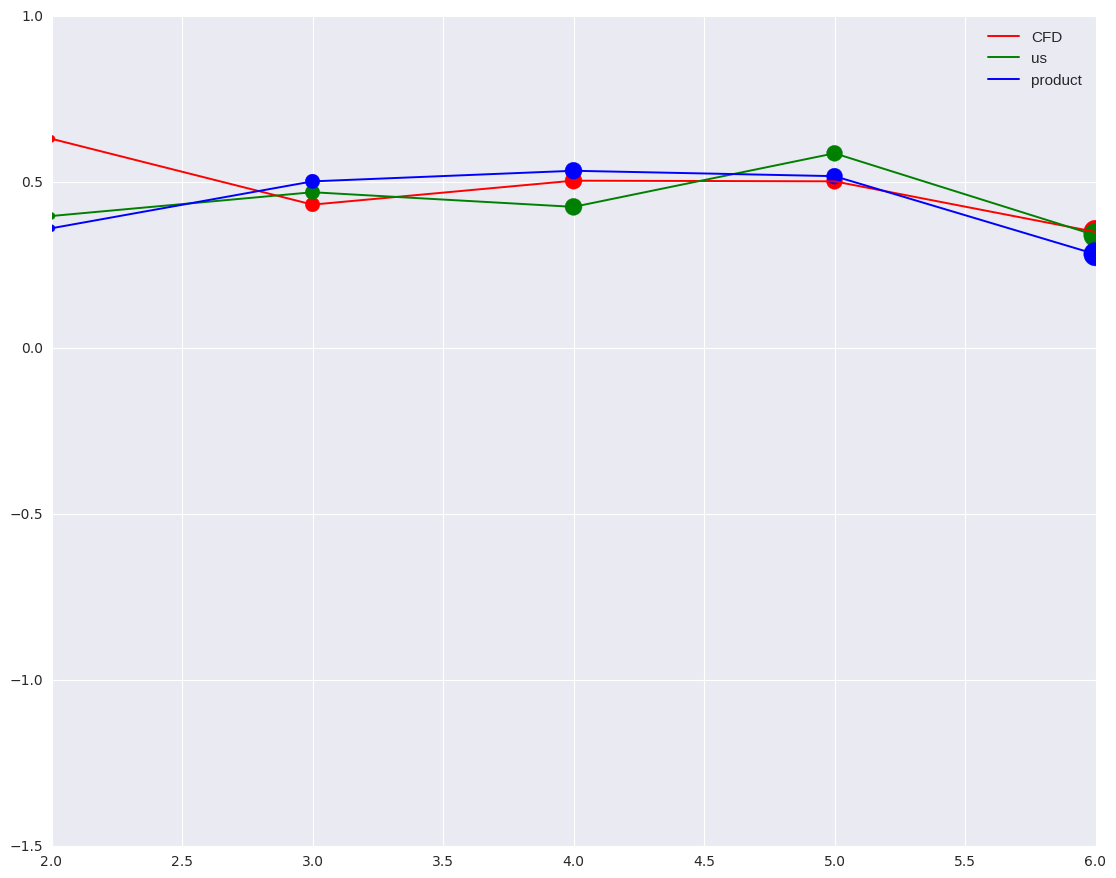

In [1175]:
plot_results = {'CFD': [],
                'us': [],
               'product': []}
model = 'linear-raw-stacker'
for m in mismatches:
    plot_results['CFD'].append(sp.stats.spearmanr(results[m-1]['CFD'].flatten(), guideseq_data['GUIDE-SEQ Reads'][test_ind[m-1]].values.flatten())[0])
    plot_results['us'].append(sp.stats.spearmanr(results[m-1][model].flatten(), guideseq_data['GUIDE-SEQ Reads'][test_ind[m-1]].values.flatten())[0])
    plot_results['product'].append(sp.stats.spearmanr(results[m-1]['product'].flatten(), guideseq_data['GUIDE-SEQ Reads'][test_ind[m-1]].values.flatten())[0])

    if m > 1:
        t2, pv, corr_cfd, corr_bm, corr01 = util.get_pval_from_predictions(results[m-1][model], 
                                                                    results[m-1]['CFD'],  
                                                                        guideseq_data['GUIDE-SEQ Reads'][test_ind[m-1]].values.flatten()[:, None], 
                                                                        twotailed=False, method='steiger')
        print m, pv

plt.figure(figsize=(12, 10))
plt.scatter(mismatches, plot_results['CFD'], s=[(num_mismatches==m).sum() for m in mismatches], color='red')
plt.plot(mismatches, plot_results['CFD'], 'r', label='CFD')
plt.scatter(mismatches, plot_results['us'], s=[(num_mismatches==m).sum() for m in mismatches], color='green')
plt.plot(mismatches, plot_results['us'], 'g', label='us')
plt.scatter(mismatches, plot_results['product'], s=[(num_mismatches==m).sum() for m in mismatches], color='blue')
plt.plot(mismatches, plot_results['product'], 'b', label='product')
# plt.plot(mismatches, plot_results['CFD'], 'o-r', label='CFD')
#plt.plot(mismatches, plot_results['us'], 'o-g', label='us')
plt.legend(loc=0)
plt.xlim((2, 6))
#plt.ylim((0., 0.8))

In [1176]:
samples = [(num_mismatches==m).sum() for m in mismatches]
# plot_results, mismatches, samples
df_gs = pandas.DataFrame(columns=['Number of mismatches', 'Sample size', 'CFD Spearman r', 
                                  'Elevation-naive Spearman r', 'Elevation Spearman r'])
df_gs['Number of mismatches'] = mismatches
df_gs['Sample size'] = samples
df_gs['CFD Spearman r'] = plot_results['CFD']
df_gs['Elevation-naive Spearman r'] = plot_results['product']
df_gs['Elevation Spearman r'] = plot_results['us']
df_gs.to_excel("plots/GuideSeq_leave_one_mismatch_out.xls")

In [1177]:
pv_guideseq = st.mannwhitneyu(performance_gs.T['CFD'], performance_gs.T[best_model], use_continuity=True, alternative='less')[1]
perf_guideseq_cfd = performance_gs.T['CFD'].median()
perf_guideseq_best_model = performance_gs.T[best_model].median()

t2, pv_gs_steiger, corr_cfd, corr_bm, corr01 = util.get_pval_from_predictions(all_cfd_pred, 
                                                                        all_best_model_pred,  
                                                                        all_truth, 
                                                                        twotailed=False, method='steiger')

print corr_cfd, corr_bm
print pv_guideseq, pv_gs_steiger

0.771542131991 0.81340144073
0.0249318451053 0.000672520003462


# Train probability calibration model

In [1178]:
prob_calibration_model = elevation.prediction_pipeline.train_prob_calibration_model(cd33_data, guideseq_data, 
                                                                                   preds_guideseq, base_model, 
                                                                                   learn_options)

# Mouse data (n=89)

linear-raw: 0.473 CFD: 0.500, product: 0.452

In [135]:
mouse_data = elevation.prediction_pipeline.load_mouse(learn_options)
for i in range(mouse_data.shape[0]):
    mouse_data.loc[mouse_data.index[i], '30mer'] = mouse_data.loc[mouse_data.index[i], '30mer'].replace('N', 
                                                                                                        mouse_data.loc[mouse_data.index[i], '30mer_mut'][20])


In [136]:
nb_pred_mouse, individual_mut_pred_mouse = elevation.prediction_pipeline.predict(base_model, mouse_data, learn_options)
pred_mouse = elevation.prediction_pipeline.stacked_predictions(mouse_data, individual_mut_pred_mouse, 
                                                               truth=mouse_data["GUIDE-SEQ Reads"], 
                                                               guideseq_data=guideseq_data_nofilter, 
                                                               models=['product', 'linear-raw-stacker', 'logistic stacker', 
                                                                       'CFD', 'HsuZhang', 'CCTOP'],
                                                               preds_guideseq=preds_guideseq_nofilter, 
                                                               prob_calibration_model=None, #prob_calibration_model,
                                                              learn_options=learn_options)

Loading CFD table from file
elapsed:  0.141391038895
Spearman r: product=0.480 linear-raw-stacker=0.477 logistic stacker=0.443 CFD=0.500 HsuZhang=0.406 CCTOP=0.309 
NDCG: product=0.409 linear-raw-stacker=0.413 logistic stacker=0.404 CFD=0.397 HsuZhang=0.413 CCTOP=0.360 


In [125]:
t2, pv_mouse, corr0, corr_naivebayes, corr01 = util.get_pval_from_predictions(pred_mouse['CFD'].flatten(), 
                                                                        pred_mouse[best_model].flatten(),  
                                                                        mouse_data["GUIDE-SEQ Reads"].values.flatten(), 
                                                                        twotailed=False, method='steiger')
print pv_mouse

0.40531524628


In [99]:
all_cfd_pred = np.concatenate([pred_mouse['CFD'][i].flatten().tolist() for i in range(len(pred_mouse['CFD']))], axis=0)
all_hsu_pred = np.concatenate([pred_mouse['HsuZhang'][i].flatten().tolist() for i in range(len(pred_mouse['HsuZhang']))], axis=0)

truth = mouse_data["GUIDE-SEQ Reads"].values

assert np.allclose(sp.stats.pearsonr(all_cfd_pred, truth)[0], 0.57, atol=1e-2)

(array([ 14.,   5.,   2.,   4.,   0.,   1.,   0.,   5.,  20.,  11.,   8.,
          5.,   2.,   3.,   0.,   2.,   2.,   2.,   0.,   3.]),
 array([ 0.00481508,  0.04030367,  0.07579226,  0.11128085,  0.14676944,
         0.18225803,  0.21774661,  0.2532352 ,  0.28872379,  0.32421238,
         0.35970097,  0.39518956,  0.43067814,  0.46616673,  0.50165532,
         0.53714391,  0.5726325 ,  0.60812109,  0.64360967,  0.67909826,
         0.71458685]),
 <a list of 20 Patch objects>)

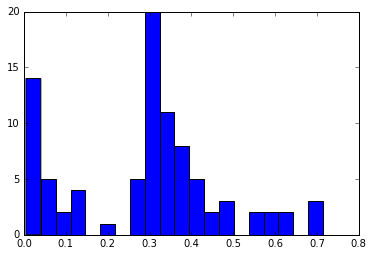

In [100]:
plt.figure(); plt.hist(pred_mouse['linear-raw-stacker'], bins=20)

In [101]:
def get_performance(prediction, truth, metric='spearman'):
    performance = {}
    for k in prediction.keys():
        if metric == 'spearman':
            performance[k] = sp.stats.spearmanr(prediction[k], truth)[0]
        elif metric == 'pearson':
            performance[k] = sp.stats.pearsonr(prediction[k].flatten(), truth.values.flatten())[0]
            
    return performance

performance_mouse = get_performance(pred_mouse, mouse_data['GUIDE-SEQ Reads'])

# Hsu data (n=825)

linear-raw: 0.419, product=0.408

In [102]:
hsu_data = elevation.prediction_pipeline.load_Hsu(learn_options)

reading and featurizing Hsu-Zhang data...
Done. Now saving to file: ../../data/offtarget/2013.HsuZhang.DNAtargetingSpec.NBT.SITab5.p


In [137]:
nb_pred, individual_mut_pred_hsu = elevation.prediction_pipeline.predict(base_model, hsu_data, learn_options)
pred_hsu = elevation.prediction_pipeline.stacked_predictions(hsu_data, individual_mut_pred_hsu, 
                                                             truth=hsu_data["GUIDE-SEQ Reads"], 
                                                             models=['CFD', 'product', 'linear-raw-stacker',
                                                                    'HsuZhang', 'CCTOP'],
                                                             guideseq_data=guideseq_data_nofilter, 
                                                             preds_guideseq=preds_guideseq_nofilter, 
                                                             prob_calibration_model=None,#prob_calibration_model,
                                                            learn_options=learn_options)

Loading CFD table from file
elapsed:  0.109152078629
Spearman r: CFD=0.272 product=0.457 linear-raw-stacker=0.459 HsuZhang=0.527 CCTOP=0.444 
NDCG: CFD=0.680 product=0.748 linear-raw-stacker=0.748 HsuZhang=0.795 CCTOP=0.797 


In [127]:
t2, pv_hsu, corr_cfd, corr_stack, corr_cfd_stack = util.get_pval_from_predictions(pred_hsu['CFD'].flatten(), 
                                                                     pred_hsu['linear-raw-stacker'].flatten(),  
                                                                     hsu_data["GUIDE-SEQ Reads"].values.flatten(), 
                                                                     twotailed=False, method='steiger')

In [105]:
print corr_cfd, corr_stack
print pv_hsu

0.271849960318 0.100442809062
6.12258092031e-05


(array([  12.,    0.,   20.,    2.,   52.,   56.,   64.,  318.,   54.,
           7.,  100.,    8.,    0.,    8.,    0.,    8.,   88.,   14.,
           0.,   14.]),
 array([ 0.11054789,  0.14183468,  0.17312147,  0.20440826,  0.23569505,
         0.26698184,  0.29826863,  0.32955542,  0.36084221,  0.392129  ,
         0.42341579,  0.45470258,  0.48598937,  0.51727616,  0.54856295,
         0.57984974,  0.61113653,  0.64242332,  0.67371012,  0.70499691,
         0.7362837 ]),
 <a list of 20 Patch objects>)

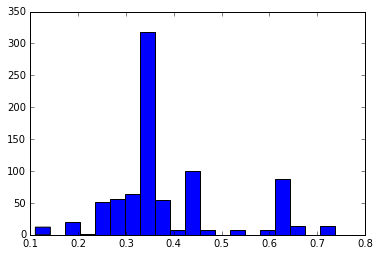

In [106]:
plt.figure(); plt.hist(pred_hsu['linear-raw-stacker'], bins=20)

In [107]:
performance_hsu = get_performance(pred_hsu, hsu_data['GUIDE-SEQ Reads'])

# Frock et al. Supplementary Table 3 data (n=33)

GP-stacker=0.344 CFD=0.159 product=0.316 linear-raw-stacker=0.366 logistic stacker=0.397 

In [138]:
nb_pred, individual_mut_pred_frock = elevation.prediction_pipeline.predict(base_model, frock_data_ST3, learn_options)
pred_frock_t3 = elevation.prediction_pipeline.stacked_predictions(frock_data_ST3, individual_mut_pred_frock, 
                                                             truth=frock_data_ST3["GUIDE-SEQ Reads"], 
                                                             models=[ 'CFD', 'product', 'linear-raw-stacker',
                                                                                'logistic stacker', 'constant-power', 'HsuZhang',
                                                                     'CCTOP'],
                                                             guideseq_data=guideseq_data_nofilter, 
                                                             preds_guideseq=preds_guideseq_nofilter, 
                                                             prob_calibration_model=None,#prob_calibration_model,
                                                              learn_options=learn_options)

Loading CFD table from file
elapsed:  0.11224603653
Spearman r: CFD=0.159 product=0.326 linear-raw-stacker=0.211 logistic stacker=0.417 constant-power=0.278 HsuZhang=0.309 CCTOP=0.248 
NDCG: CFD=0.631 product=0.704 linear-raw-stacker=0.695 logistic stacker=0.706 constant-power=0.588 HsuZhang=0.561 CCTOP=0.634 


In [133]:
t2, pv_frocks3, corr_cfd, corr_stack, corr_cfd_stack = util.get_pval_from_predictions(pred_frock_t3['HsuZhang'].flatten(), 
                                                                     pred_frock_t3['linear-raw-stacker'].flatten(),  
                                                                     frock_data_ST3["GUIDE-SEQ Reads"].values.flatten(), 
                                                                     twotailed=False, method='steiger')
print corr_cfd, corr_stack
print pv_frocks3

0.308515084222 0.170120320856
0.25060685124


(array([ 6.,  5.,  3.,  4.,  1.,  2.,  0.,  1.,  2.,  3.,  0.,  1.,  1.,
         1.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0.0039935 ,  0.00940504,  0.01481657,  0.02022811,  0.02563964,
         0.03105118,  0.03646271,  0.04187425,  0.04728578,  0.05269731,
         0.05810885,  0.06352038,  0.06893192,  0.07434345,  0.07975499,
         0.08516652,  0.09057806,  0.09598959,  0.10140112,  0.10681266,
         0.11222419]),
 <a list of 20 Patch objects>)

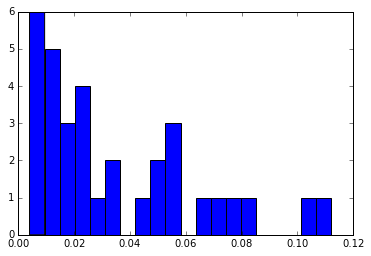

In [110]:
plt.figure(); plt.hist(pred_frock_t3['linear-raw-stacker'], bins=20)

In [111]:
performance_frockt3 = get_performance(pred_frock_t3, frock_data_ST3['GUIDE-SEQ Reads'])

# Frock et al. Supplementary Table 7 data (n=51)

Spearman r: GP-stacker=0.546 CFD=0.435 product=0.539 linear-raw-stacker=0.554 logistic stacker=0.492 

In [139]:
nb_pred, individual_mut_pred_frock = elevation.prediction_pipeline.predict(base_model, frock_data_ST7, learn_options)
pred_frock_t7, m_stack, f_stack = elevation.prediction_pipeline.stacked_predictions(frock_data_ST7, individual_mut_pred_frock, 
                                                             truth=frock_data_ST7["GUIDE-SEQ Reads"], 
                                                             models=['CFD', 'product', 'linear-raw-stacker',
                                                                                'logistic stacker', 'constant-power', 'HsuZhang',
                                                                    'CCTOP'],
                                                             guideseq_data=guideseq_data, 
                                                             preds_guideseq=preds_guideseq, 
                                                             prob_calibration_model=None,#prob_calibration_model,
                                                              learn_options=learn_options, 
                                                              return_model = True)

Loading CFD table from file
elapsed:  0.127134084702
Spearman r: CFD=0.435 product=0.512 linear-raw-stacker=0.539 logistic stacker=0.473 constant-power=0.426 HsuZhang=0.490 CCTOP=0.471 
NDCG: CFD=0.830 product=0.677 linear-raw-stacker=0.677 logistic stacker=0.738 constant-power=0.675 HsuZhang=0.699 CCTOP=0.836 


In [131]:
t2, pv_frocks7, corr_cfd, corr_stack, corr_cfd_stack = util.get_pval_from_predictions(pred_frock_t7['HsuZhang'].flatten(), 
                                                                     pred_frock_t7['linear-raw-stacker'].flatten(),  
                                                                     frock_data_ST7["GUIDE-SEQ Reads"].values.flatten(), 
                                                                     twotailed=False, method='steiger')
print corr_cfd, corr_stack
print pv_frocks7

0.4899196753 0.504355697508
0.44667344305


(array([  3.,   4.,   4.,  11.,  11.,   2.,   4.,   2.,   3.,   1.,   0.,
          1.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 0.00397202,  0.04310192,  0.08223182,  0.12136172,  0.16049161,
         0.19962151,  0.23875141,  0.27788131,  0.31701121,  0.3561411 ,
         0.395271  ,  0.4344009 ,  0.4735308 ,  0.5126607 ,  0.55179059,
         0.59092049,  0.63005039,  0.66918029,  0.70831019,  0.74744008,
         0.78656998]),
 <a list of 20 Patch objects>)

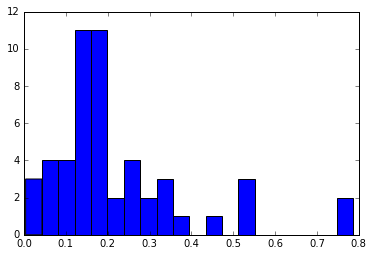

In [132]:
plt.figure(); plt.hist(pred_frock_t7['linear-raw-stacker'], bins=20)

In [115]:
performance_frockt7 = get_performance(pred_frock_t7, frock_data_ST7['GUIDE-SEQ Reads'])

# Cross-validate CD33

In [1199]:
# %%capture
import copy
label_encoder = sklearn.preprocessing.LabelEncoder()
cv_classes = label_encoder.fit_transform(cd33_data['Category'])

skf = sklearn.cross_validation.StratifiedKFold(cv_classes, n_folds=20, shuffle=True)
# skf = sklearn.cross_validation.KFold(cd33_data.shape[0], n_folds=20, shuffle=True)
spearman_scores_cd33 = {'CFD': [], 'ours': [], 'product': [], 'hsu':[]}
pearson_scores_cd33 = {'CFD': [], 'ours': [], 'product': [], 'hsu':[]}
cfd_all_preds_cd33 = np.zeros((len(cv_classes)))
ours_all_preds_cd33 = np.zeros((len(cv_classes)))
product_all_preds_cd33 = np.zeros((len(cv_classes)))
all_truth_cd33 = np.zeros((len(cv_classes)))
categories = np.zeros((len(cv_classes)))

for train, test in skf:
    learn_options_fold = copy.deepcopy(learn_options)
    learn_options_fold['training_indices'] = train
    base_model_i = train_base_model(learn_options_fold)[0]
    preds_guideseq_i = elevation.prediction_pipeline.predict_guideseq(base_model_i, guideseq_data, learn_options_fold,
                                                                    naive_bayes_combine=True)
    
    nb_pred, individual_mut_predictions = predict(base_model_i, cd33_data.iloc[test], learn_options)
    
    preds_all = elevation.prediction_pipeline.stacked_predictions(cd33_data.iloc[test], individual_mut_predictions, 
                                                             models=['linear-raw-stacker', 'HsuZhang'],
                                                             guideseq_data=guideseq_data, 
                                                             preds_guideseq=preds_guideseq_i, 
                                                             use_mut_distances=False,
                                                             prob_calibration_model=None,
                                                              learn_options=learn_options_fold)
    
    
    preds_i = preds_all['linear-raw-stacker']
    preds_ih = preds_all['HsuZhang']

    cfd_train = make_cfd_from_data(learn_options=learn_options_fold)
    m1 = elevation.models.CFDModel(cfd_table=cfd_train)
    cfd_pred =  m1.predict(cd33_data.iloc[test]['Annotation'])
    truth = cd33_data.iloc[test]['Day21-ETP']

    all_truth_cd33[test] = truth.copy()
    ours_all_preds_cd33[test] = nb_pred.copy()
    cfd_all_preds_cd33[test] = cfd_pred.copy()
    categories[test] = cv_classes[test]

    spearman_scores_cd33['ours'].append(sp.stats.spearmanr(preds_i, truth)[0])
    spearman_scores_cd33['product'].append(sp.stats.spearmanr(nb_pred, truth)[0])
    spearman_scores_cd33['CFD'].append(sp.stats.spearmanr(cfd_pred, truth)[0])
    spearman_scores_cd33['hsu'].append(sp.stats.spearmanr(preds_ih, truth)[0])
    pearson_scores_cd33['product'].append(sp.stats.pearsonr(nb_pred, truth)[0])
    pearson_scores_cd33['ours'].append(sp.stats.pearsonr(preds_i, truth)[0])
    pearson_scores_cd33['CFD'].append(sp.stats.pearsonr(cfd_pred, truth)[0])
    print spearman_scores_cd33

Received option CV=False, so I'm training using all of the data
running AdaBoost, order 1 for final
MKL not available, so I'm not adjusting the number of threads
Launching 1 jobs with 1 MKL threads each
loading processed data from file: ../../data/offtarget/CD33.processed.[4, 27, 30].pamfiltTrue.p...
done.
{'bandwidth': 0.23000000000000001}
featurizing data...
done.
range of y_all is [0.000002, 1.000000]
filename = VCD33AdaBoostRegressor.order1Day21-ETP.gene.spearman
Cross-validating genes...
Adaboost with GridSearch
Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.7s


KeyboardInterrupt: 

In [ ]:
spearman_scores_cd33

# Figures and statistics

### 1) CD33 cross validation

In [1115]:
for k in spearman_scores_cd33.keys():
    print "%s, median Spearman %.4f, median Pearson %.4f" % (k, np.median(spearman_scores_cd33[k]), np.median(pearson_scores_cd33[k]))

ours, median Spearman 0.7842, median Pearson 0.7696
CFD, median Spearman 0.5936, median Pearson 0.5660
product, median Spearman 0.7852, median Pearson 0.7732
hsu, median Spearman 0.3456, median Pearson nan


 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning:Mean of empty slice.


In [1116]:
t2, pv, corr_cfd, corr_bm, corr01 = util.get_pval_from_predictions(cfd_all_preds_cd33, ours_all_preds_cd33, all_truth_cd33, 
                                                                        twotailed=False, method='steiger')
print "Steiger pv: %.4f" % pv

Steiger pv: 0.0000


### 2) Guideseq

In [1117]:
models_to_print = ['CFD', 'linear-raw-stacker']
for k in models_to_print:
    sp_k = np.median([sp.stats.spearmanr(predictions_gs[k][c], truth_gs[c])[0] for c in range(len(predictions_gs[k]))])
    pe_k = np.median([sp.stats.pearsonr(predictions_gs[k][c].flatten(), truth_gs[c].flatten())[0] for c in range(len(predictions_gs[k]))])
    print "%s, median Spearman %.4f, median Pearson %.4f" % (k, sp_k, pe_k)

CFD, median Spearman 0.7624, median Pearson 0.6572
linear-raw-stacker, median Spearman 0.8333, median Pearson 0.7555


In [ ]:
# TODO steiger

In [1200]:
feat = pandas.DataFrame(index=base_feature_names, data=base_model.feature_importances_, columns=['Gini importance'])
feat_sorted = feat.sort_values(axis=0, ascending=False, by='Gini importance')
feat_sorted_filt = feat_sorted[feat_sorted['Gini importance'] > 0]

feat_sorted.to_excel('plots/base_model_feature_importances.xls')

feature_groups = {'nucleotides': [],
                  'mutation ident.': [],
                  'mutation position': [],
                  'mutation trans.': [],
                  'GC content': []}

for f in feat_sorted_filt.index:
    if ":" in f:
        feature_groups['mutation ident.'].append(f)
    elif "pos" in f:
        feature_groups['mutation position'].append(f)
    elif "_" in f:
        feature_groups['nucleotides'].append(f)
    elif "GC " in f:
        feature_groups['GC content'].append(f)
    elif 'trans' in f or 'translation' in f:
        feature_groups['mutation trans.'].append(f)
    else: # it's a PAM
        feature_groups['mutation ident.'].append(f)
        
names, values = [], []
for fg in feature_groups.keys():
    names.append(fg)
    values.append(feat_sorted_filt.loc[feature_groups[fg]].sum().values[0])

ind = np.argsort(values)[::-1]
names = np.array(names)[ind]
values = np.array(values)[ind]
plt.style.use(['seaborn-darkgrid', 'seaborn-paper'])
# plt.style.use(['fivethirtyeight'])
plt.figure(facecolor='white')
w = 0.4
matplotlib.rcParams.update({'xtick.labelsize': 10,
                           'ytick.labelsize': 10,
                           'axes.labelsize': 10,
                           'font.size': 10,
                           'savefig.facecolor': 'white', })
plt.ylabel('Gini importance')
plt.bar(np.arange(len(values))+w, values, w)
plt.xticks(np.arange(len(values))+w+w/2, names, rotation=0)
plt.savefig('plots/base_feature_importances.pdf')

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [1201]:
names = ['CD33\n(N=%d)' % len(cd33_data), 
         'GUIDE-seq\n(N=%d)' % len(guideseq_data),  
         'Hsu et al.\n(N=%d)' % len(hsu_data), 
         'Frock et al. S3\n(N=%d)' % len(frock_data_ST3), 
         'Frock et al. S7\n(N=%d)' % len(frock_data_ST7),
        'Mouse\n(N=%d)' % len(mouse_data),]
values = {'CFD': [np.median(spearman_scores_cd33['CFD']), 
                  np.median(performance_gs.T['CFD'].values),
                 performance_hsu['CFD'],
                 performance_frockt3['CFD'],
                 performance_frockt7['CFD'],
                 performance_mouse['CFD'],],
          'us': [np.median(spearman_scores_cd33['ours']), 
                 np.median(performance_gs.T['linear-raw-stacker'].values),
                 performance_hsu['linear-raw-stacker'],
                 performance_frockt3['linear-raw-stacker'],
                 performance_frockt7['linear-raw-stacker'],
                performance_mouse['linear-raw-stacker'],],
          'product': [np.median(spearman_scores_cd33['product']), 
                      np.median(performance_gs.T['product'].values),
                     performance_hsu['product'],
                     performance_frockt3['product'],
                     performance_frockt7['product'],
                     performance_mouse['product'],],
         'hsu': [np.median(spearman_scores_cd33['hsu']),
                 np.median(performance_gs.T['HsuZhang'].values),
                      0.0,
                     performance_frockt3['HsuZhang'],
                     performance_frockt7['HsuZhang'],
                     performance_mouse['HsuZhang'],]} 

errors = {'CFD':
                 [[np.abs(np.percentile(spearman_scores_cd33['CFD'], 25) - values['CFD'][0]), 
                   np.abs(np.percentile(spearman_scores_cd33['CFD'], 75) - values['CFD'][0])],
                  [np.abs(np.percentile(performance_gs.T['CFD'], 25) - values['CFD'][1]), 
                   np.abs(np.percentile(performance_gs.T['CFD'], 75) - values['CFD'][1])]],
          
          'us':
                 [[np.abs(np.percentile(spearman_scores_cd33['ours'], 25) - values['us'][0]), 
                   np.abs(np.percentile(spearman_scores_cd33['ours'], 75) - values['us'][0])],
                  [np.abs(np.percentile(performance_gs.T['linear-raw-stacker'], 25) - values['us'][1]), 
                   np.abs(np.percentile(performance_gs.T['linear-raw-stacker'], 75) - values['us'][1])]],        
          
          'product':
                 [[np.abs(np.percentile(spearman_scores_cd33['product'], 25) - values['product'][0]), 
                   np.abs(np.percentile(spearman_scores_cd33['product'], 75) - values['product'][0])],
                  [np.abs(np.percentile(performance_gs.T['product'], 25) - values['product'][1]), 
                   np.abs(np.percentile(performance_gs.T['product'], 75) - values['product'][1])]],
         
          'hsu':
                 [[np.abs(np.percentile(spearman_scores_cd33['product'], 25) - values['product'][0]), 
                   np.abs(np.percentile(spearman_scores_cd33['product'], 75) - values['product'][0])],
                  [np.abs(np.percentile(performance_gs.T['HsuZhang'], 25) - values['hsu'][1]), 
                   np.abs(np.percentile(performance_gs.T['HsuZhang'], 75) - values['hsu'][1])]],
         
         
         }

def get_stars(pv):
    if pv <= 0.01:
        return "***"
    if pv <= 0.025:
        return "**"
    if pv <= 0.05:
        return "*"
    else:
        return ""
    
stars = [get_stars(p) for p in [0.0, pv_gs_steiger, pv_hsu, pv_frocks3, pv_frocks7, pv_mouse]]

cfd_color = '#d7191c'
naive_color = '#fdae61'
elevation_color = '#2c7bb6'
ind = np.arange(len(names))
width = 0.15

matplotlib.rcParams.update({'xtick.labelsize': 10,
                           'ytick.labelsize': 10,
                           'axes.labelsize': 10,
                           'font.size': 12,
                           'legend.fontsize': 11})

plt.figure(figsize=(8, 6), facecolor='white')

plt.bar(ind[:2], values['CFD'][:2], width, yerr=np.array(errors['CFD']).T, color=cfd_color, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind[2:], values['CFD'][2:], width, color=cfd_color, label='CFD')

plt.bar(ind[:2]+width, values['product'][:2], width, yerr=np.array(errors['product']).T, color=naive_color, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind[2:]+width, values['product'][2:], width, color=naive_color, label='Elevation-naive')

plt.bar(ind[:2]+width*2, values['us'][:2], width, yerr=np.array(errors['us']).T, color=elevation_color, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind[2:]+width*2, values['us'][2:], width, color=elevation_color, label='Elevation')

plt.bar(ind[:2]+width*3, values['hsu'][:2], width, yerr=np.array(errors['hsu']).T, color='k', label='Hsu', error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind[2:]+width*3, values['hsu'][2:], width,  color='k', error_kw={'elinewidth': 0.7, 'ecolor': 'k'})

plt.legend(loc=0)
plt.ylim(0.0, 1.0)
plt.ylabel('Spearman correlation')
plt.xticks(ind+width+width/2., names)

for i in range(len(values['us'])):
    pos = values['us'][i]

    plt.text(ind[i]+width+width, pos+0.08, stars[i])
    
plt.savefig('plots/Spearman_across_data.pdf')

IndexError: cannot do a non-empty take from an empty axes.

In [ ]:
names = ['CD33\n(N=%d)' % len(cd33_data), 
         'GUIDE-seq\n(N=%d)' % len(guideseq_data),  
         'Hsu et al.\n(N=%d)' % len(hsu_data), 
         'Frock et al. S3\n(N=%d)' % len(frock_data_ST3), 
         'Frock et al. S7\n(N=%d)' % len(frock_data_ST7),
        'Mouse\n(N=%d)' % len(mouse_data),]

performance_mouse_p = get_performance(pred_mouse, mouse_data['GUIDE-SEQ Reads'], 'pearson')
performance_frockt7_p = get_performance(pred_frock_t7, frock_data_ST7['GUIDE-SEQ Reads'], 'pearson')
performance_frockt3_p = get_performance(pred_frock_t3, frock_data_ST3['GUIDE-SEQ Reads'], 'pearson')
performance_hsu_p = get_performance(pred_hsu, hsu_data['GUIDE-SEQ Reads'], 'pearson')
performance_gs_p = pandas.DataFrame(data=np.zeros((len(predictions_gs.keys()), len(truth_gs))), 
                                    columns=['Fold %d' % (i+1) for i in range(len(truth_gs))], 
                                    index=[model for model in predictions_gs.keys()])
for fold in range(len(truth_gs)):
    for model in predictions_gs.keys():
        performance_gs_p['Fold %d' % (fold+1)].T[model] = sp.stats.pearsonr(predictions_gs[model][fold].flatten(), truth_gs[fold].flatten())[0]
        
values = {'CFD': [np.median(pearson_scores_cd33['CFD']), 
                  np.median(performance_gs_p.T['CFD'].values),
                 performance_hsu_p['CFD'],
                 performance_frockt3_p['CFD'],
                 performance_frockt7_p['CFD'],
                 performance_mouse_p['CFD'],],
          'us': [np.median(spearman_scores_cd33['ours']), 
                 np.median(performance_gs_p.T['linear-raw-stacker'].values),
                 performance_hsu_p['linear-raw-stacker'],
                 performance_frockt3_p['linear-raw-stacker'],
                 performance_frockt7_p['linear-raw-stacker'],
                performance_mouse_p['linear-raw-stacker'],],
          'product': [np.median(spearman_scores_cd33['product']), 
                      np.median(performance_gs_p.T['product'].values),
                     performance_hsu_p['product'],
                     performance_frockt3_p['product'],
                     performance_frockt7_p['product'],
                     performance_mouse_p['product'],]} 

errors = {'CFD':
                 [[np.abs(np.percentile(pearson_scores_cd33['CFD'], 25) - values['CFD'][0]), 
                   np.abs(np.percentile(pearson_scores_cd33['CFD'], 75) - values['CFD'][0])],
                  [np.abs(np.percentile(performance_gs_p.T['CFD'], 25) - values['CFD'][1]), 
                   np.abs(np.percentile(performance_gs_p.T['CFD'], 75) - values['CFD'][1])]],
          
          'us':
                 [[np.abs(np.percentile(pearson_scores_cd33['ours'], 25) - values['us'][0]), 
                   np.abs(np.percentile(pearson_scores_cd33['ours'], 75) - values['us'][0])],
                  [np.abs(np.percentile(performance_gs_p.T['linear-raw-stacker'], 25) - values['us'][1]), 
                   np.abs(np.percentile(performance_gs_p.T['linear-raw-stacker'], 75) - values['us'][1])]],        
          
          'product':
                 [[np.abs(np.percentile(pearson_scores_cd33['product'], 25) - values['product'][0]), 
                   np.abs(np.percentile(pearson_scores_cd33['product'], 75) - values['product'][0])],
                  [np.abs(np.percentile(performance_gs_p.T['product'], 25) - values['product'][1]), 
                   np.abs(np.percentile(performance_gs_p.T['product'], 75) - values['product'][1])]]}

def get_stars(pv):
    if pv <= 0.01:
        return "***"
    if pv <= 0.025:
        return "**"
    if pv <= 0.05:
        return "*"
    else:
        return ""
    
stars = [get_stars(p) for p in [0.0, pv_gs_steiger, pv_hsu, pv_frocks3, pv_frocks7, pv_mouse]]

cfd_color = '#d7191c'
naive_color = '#fdae61'
elevation_color = '#2c7bb6'
ind = np.arange(len(names))
width = 0.25

matplotlib.rcParams.update({'xtick.labelsize': 10,
                           'ytick.labelsize': 10,
                           'axes.labelsize': 10,
                           'font.size': 12,
                           'legend.fontsize': 11})

plt.figure(figsize=(8, 6), facecolor='white')
plt.bar(ind[:2], values['CFD'][:2], width, yerr=np.array(errors['CFD']).T, color=cfd_color, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind[2:], values['CFD'][2:], width, color=cfd_color, label='CFD')
plt.bar(ind[:2]+width, values['product'][:2], width, yerr=np.array(errors['product']).T, color=naive_color, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind[2:]+width, values['product'][2:], width, color=naive_color, label='Elevation-naive')
plt.bar(ind[:2]+width*2, values['us'][:2], width, yerr=np.array(errors['us']).T, color=elevation_color, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind[2:]+width*2, values['us'][2:], width, color=elevation_color, label='Elevation')


plt.legend(loc=0)
plt.ylim(0.0, 1.0)
plt.ylabel('Pearson correlation')
plt.xticks(ind+width+width/2., names)

for i in range(len(values['us'])):
    pos = values['us'][i]

    plt.text(ind[i]+width, pos+0.08, stars[i])
    
plt.savefig('plots/Pearson_across_data.pdf')

In [ ]:
predictions_gs['CFD'], truth_gs

In [ ]:
plt.figure(facecolor='white')
coef = m_stack.coef_

meta_coef = coef[-3:]
nucl_coef = coef[:-3]

names = []
for n in f_stack:
    if 'pos' in n:
        l = n.replace('pos', '')
        if l == '21':
            l = 'N'
        names.append(l)
    elif 'annotations' in n:
        names.append(n.replace('annotations', 'mismatches'))
    else:
        names.append(n)
        
ind = np.arange(len(coef))
width = 0.8
plt.bar(ind[:-3], nucl_coef, width, color=elevation_color)
plt.bar(ind[-3:], meta_coef, width, color=cfd_color)
plt.xticks(ind+width/2., names, rotation=90)
#bbox_inches='tight'
plt.tight_layout()
plt.ylabel('feature weight')
plt.savefig('plots/stacker_feat_importances.pdf')
#plt.xticks(ind[-3:]+width/2., names[-3:], rotation=80)

## Classification vs Regression

In [ ]:
learn_options_class = copy.deepcopy(learn_options)
learn_options_class['models'] = ['AdaBoostClassifier']
learn_options_class['phen_transform'] = 'binarize'

In [ ]:
base_model_class, base_feature_names_class = elevation.prediction_pipeline.train_base_model(learn_options_class)
preds_guideseq_class = elevation.prediction_pipeline.predict_guideseq(base_model_class, guideseq_data, learn_options_class,
                                                                naive_bayes_combine=True)
predictions_gs_class, performance_gs_class, mismatches_gs_class, truth_gs_class, c_pred_class =  elevation.prediction_pipeline.cross_validate_guideseq(guideseq_data, 
                                                                                                     preds_guideseq_class, 
                                                                                                     learn_options_class,
                                                                                models= ['GP-stacker', 'CFD', 'product',
                                                                               'linear-raw-stacker'])

## Old vs new features

In [ ]:
learn_options_feat = copy.deepcopy(learn_options)
learn_options_feat['azimuth_feat'] = None
learn_options_feat['annotation_decoupled_onehot'] = False
learn_options_feat['annotation_onehot'] = True

In [ ]:
base_model_feat, base_feature_names_feat = elevation.prediction_pipeline.train_base_model(learn_options_feat)
preds_guideseq_feat = elevation.prediction_pipeline.predict_guideseq(base_model_feat, guideseq_data, learn_options_feat,
                                                                naive_bayes_combine=True)
predictions_gs_feat, performance_gs_feat, mismatches_gs_feat, truth_gs_feat, c_pred_feat =  elevation.prediction_pipeline.cross_validate_guideseq(guideseq_data, 
                                                                                                     preds_guideseq_feat, 
                                                                                                     learn_options_feat,
                                                                                models= ['GP-stacker', 'CFD', 'product',
                                                                               'linear-raw-stacker'])

In [ ]:
values = [np.median(performance_gs.T['CFD']),
          np.median(performance_gs.T['linear-raw-stacker']), 
          np.median(performance_gs_class.T['linear-raw-stacker']), 
          np.median(performance_gs_feat.T['linear-raw-stacker'])]

errors = [[[np.abs(np.percentile(performance_gs.T['CFD'], 25) - values[0])], 
           [np.abs(np.percentile(performance_gs.T['CFD'], 75) - values[0])]],
          
          [[np.abs(np.percentile(performance_gs.T['linear-raw-stacker'], 25) - values[1])], 
           [np.abs(np.percentile(performance_gs.T['linear-raw-stacker'], 75) - values[1])]],
          
          [[np.abs(np.percentile(performance_gs_class.T['linear-raw-stacker'], 25) - values[2])], 
           [np.abs(np.percentile(performance_gs_class.T['linear-raw-stacker'], 75) - values[2])]],
          
          [[np.abs(np.percentile(performance_gs_feat.T['linear-raw-stacker'], 25) - values[3])], 
           [np.abs(np.percentile(performance_gs_feat.T['linear-raw-stacker'], 75) - values[3])]]]

names = ['CFD', 'Elevation', 'Elevation-classification', 'Elevation-simple-feat']
plt.figure(facecolor='white')
ind = np.array([1])
width=0.3
plt.figure()
plt.bar(ind, [values[0]], width, color=cfd_color, yerr=errors[0], label=names[0], error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind+width*1, [values[2]], width, color='#f4a582', yerr=errors[2], label=names[2], error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind+width*2, [values[3]], width, color='#92c5de', yerr=errors[3], label=names[3], error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.bar(ind+width*3, [values[1]], width, color=elevation_color, yerr=errors[1], label=names[1], error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
plt.ylim(0.0, 0.7)
plt.xlim(0.3, 4.0)
plt.legend(loc=0)
plt.ylabel('Spearman correlation')
plt.xticks([])
plt.savefig("plots/class_vs_feat_vs_elevation.pdf")

In [ ]:
plt.plot(m_stack.alphas_, 'o-')

In [ ]:
m_stack.alphas_.min(), m_stack.alphas_.max() 

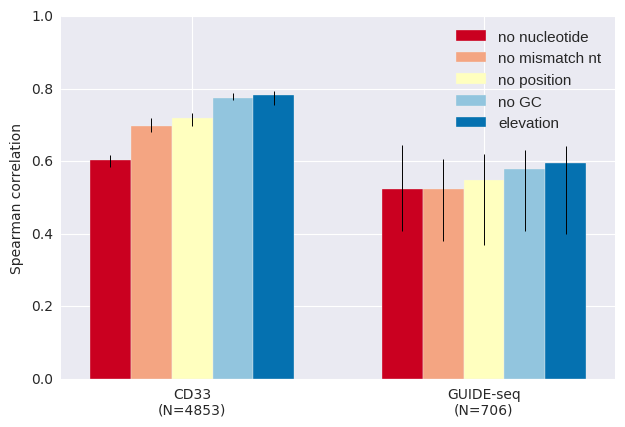

In [1132]:
def median_dist(median, q1, q3):
    return median, [[np.abs(q1-median)], [np.abs(q3-median)]]

cd_33_exp = {'elevation': [0.78198, 0.754171, 0.793050],
            'no position': [0.719615, 0.696937,0.732687],
            'no mismatch nt': [0.697318, 0.681226, 0.719169],
            'no nucleotide': [0.604790, 0.584646, 0.618526],
            'no GC': [0.775354, 0.767718, 0.786855]}

gs_exp = {'elevation': [0.595256, 0.398174, 0.641509],
            'no position': [0.547643, 0.368088, 0.618912],
            'no mismatch nt': [0.523239, 0.380507, 0.605046],
            'no nucleotide': [0.523052, 0.407058,0.644489],
            'no GC': [0.579782, 0.407438, 0.631960]}

colors = ['#ca0020', '#f4a582', '#ffffbf', '#92c5de', '#0571b0']

width=0.7/len(cd_33_exp.keys())
ind = 0
for i, n in enumerate(['elevation', 'no GC', 'no position', 'no mismatch nt', 'no nucleotide'][::-1]):
    med, err = median_dist(*cd_33_exp[n])
    plt.bar(ind+(width*i), med, width, color=colors[i], 
            yerr=err, label=n, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})
    med, err = median_dist(*gs_exp[n])
    plt.bar(ind+1+(width*i), med, width, color=colors[i], 
            yerr=err, error_kw={'elinewidth': 0.7, 'ecolor': 'k'})


plt.xlim(-0.1, 1.8)
plt.ylim(0.0, 1.0)
plt.legend(loc=0)
plt.ylabel('Spearman correlation')
plt.xticks(np.array([0, 1])+width*2+width/2., ['CD33\n(N=%d)' % len(cd33_data), 
         'GUIDE-seq\n(N=%d)' % len(guideseq_data)])
plt.tight_layout()
plt.savefig('plots/feature_importances_removing.pdf')

In [ ]:
hsu_data